<div width=50% style="display: block; margin: auto">
    <img src="figures/ucl-logo.svg" width=100%>
</div>

### [UCL-ELEC0135 Advanced Machine Learning Systems II - 2025]()
University College London
# Lab 3: Reinforcement Learning


<hr width=70% style="float: left">

### Introduction

Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by interacting with its environment. Through trial and error, the agent observes the outcomes of its actions and gradually learns to take optimal actions to maximize long-term rewards. RL is widely used in areas such as game AI, robotics, and recommendation systems, making it a fundamental tool for building intelligent systems.

In this lab, you will use **Gymnasium**, a widely used RL library, to train different types of models to play **Blackjack**, a classic card game of decision-making under uncertainty. You will explore various RL approaches, from **tabular Q-learning** to **Deep Q Networks (DQN) with Experience Replay**, and observe how different training strategies affect the agent's performance. Through Gymnasium’s Blackjack environment, you will gain hands-on experience in defining states, actions, and rewards in a real-world game setting.

By the end of this lab, you will have a solid understanding of reinforcement learning principles and practical experience in training RL agents using **Gymnasium**. You will also compare different RL models and analyze their effectiveness in learning Blackjack strategies.

### Intended Learning Outcome
* Understand what the core components of a Gymnasium Reinforcement Learning environment.
* Implement TD Learning with an epsilon greedy policy on a tabular agent.
* Implement TD Learning with an epsilon greedy policy on a Deep Q-Network (DQN) agent.
* Realise the importance of vectorisation for efficient learning.
* Implement experience replay to improve the DQN agent.
* Implement double-DQN to improve the DQN agent.

### Outline

This notebook has 3 parts:

0. [Setting up](#0.-Setting-up)
1. [Defining and Training a tabular Q-Learning agent](#1-defining-and-training-a-tabular-q-learning-agent)
2. [Defining and Training a Deep Q-Network agent](#2-defining-and-training-a-deep-q-network-agent)
3. [Improving the DQN agent performences](#3-improving-the-dqn-agents-performences)

<hr width=70% style="float: left">

# 0. Setting up

## 0.1 Importing librairies

### Gymnasium

![](figures/gymnasium-text.png)

[Gymnasium](https://gymnasium.farama.org) is a Python library for developing and evaluating reinforcement learning (RL) algorithms maintained by the nonprofit [Farama](https://farama.org). It provides a standardized API for RL environments, allowing researchers and developers to easily test and compare RL agents across different tasks. 

Gymnasium is a maintained fork of [OpenAI Gym](https://www.gymlibrary.dev/index.html), created after OpenAI stopped actively supporting Gym. It builds on Gym’s core functionality while introducing bug fixes, enhanced support for modern RL libraries, and better long-term maintenance. Many RL frameworks, such as Stable-Baselines3 and RLlib, now support Gymnasium as a direct replacement for Gym. 

Gymnasium contains in its source code multiple canonical environments meant to serve as tutorial examples and research benchmarks. It also provides documentation on how to create custom third party environments.


<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Make sure you are running this Notebook in the kernel of the virtual environment you created for this module.
- Run the following cell. If some packages have not been installed, add them to the requirements.txt file, and run in terminal (after having activated the virtual environment you created) the command `pip install -r requirements.txt`. 

</div>

<div class="alert alert-block alert-info"> 
<b>💡 Tips</b> 

- Make sure to specify `numpy<2` in the `requirements.txt` file.

</div>

In [1]:
# Libraries
from collections import defaultdict
import numpy as np
import gymnasium as gym
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

2025-02-08 20:49:21.761961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Functions and classes for the utils.py file
from utils import evaluate_blackjack_agent # Function to evaluate the agent in the Blackjack environment on a number of episodes
from utils import unpack_qvalues_dict # Function to unpack the Q-values dictionary into a matrix
from utils import get_best_actions_from_DQN # Function to get the Q-values from the DQN model
from utils import ExperienceReplayBuffer # Class for the experience replay buffer

## 0.2 Setting up the RL environment and evaluating benchmark win rates values

In this lab, we will train an agent to play the game Blackjack. We must first setup an environment, i.e the external system or simulation with which the agent interacts, providing states, receiving actions, and returning rewards and new states based on those actions.

### The Gymnasium BlackJack Environment

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Read the following, and make sure you understand clearly the rules of the game we are training a RL agent for.

</div>

[Gymnasium's Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/#blackjack_ref) environment implements the Blackjack game discribed in [Reinforcement learning : an introduction / Richard S. Sutton and Andrew G. Barto.](http://www.incompleteideas.net/book/RLbook2020.pdf) example 5.1 on page 93 (giving you a free textbook, you're welcome).

![](figures/blackjack.gif)

1. **Observation Space**:
  - The **observation space** represents the state of the environment visible to the agent.
  - In the game Blackjack, the observation consists of a 3-tuple containing: the player’s current sum (between 0 and 32), the value of the dealer’s one showing card (1-10 where 1 is ace), and whether the player holds a usable ace (0 or 1)
  - `obs: (int, int, bool)`

2. **Action Space**:
  - The **action space** defines the possible moves the agent can take.
  - In the game Blackjack, the action concists of a signle value in the range {0, 1} indicating whether to stick (stop playing) or hit (ask for another card).
  - `action: bool`

3. **Rewards**:
  - The agent receives a reward based on its actions:
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack: +1.5 (if natural is True) +1 (if natural is False)
  - `reward: float`

4. **Dynamics**:
  - The environment updates based on the agent's actions and defined transition rules.
  - The episode ends if the following happens:
    - The player hits and the sum of hand exceeds 21.
    - The player sticks.
    - An ace will always be counted as usable (11) unless it busts the player.

---





### Benchmark win rates

To assess our agents' performances, let's create two policies manually that will serve as benchmarcks.

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Implement the function `random_policy` in the cell below to randomly select an action to play at each turn, independently of the observation.
- Implement the function `basic_strategy`in the cell below to follow the policy:
    - If the player sum is stricktly bellow 12, hit (action 1).
    - If the player sum is stricktly above 17, stick (action 0).
    - If the player sum is between 16 and 16, and that the dealer has a card above 7, hit (action 1).

</div>

In [3]:
# Define the Random Policy
def random_policy(obs, env):
    """
    A random policy that samples actions uniformly at random.

    Args:
        obs: The current observation.
    """
    # Return a random action
    # TODO: Implement the random policy
    return env.action_space.sample()

# Define the Basic Strategy Agent
def basic_strategy(obs,env):
    """
    Implements a simple Blackjack basic strategy.
    - Hit if player's sum is < 12.
    - Stick if sum is >= 17.
    - For 12-16, hit if the dealer has a high card (7 or higher).
    """
    # Unpack the observation
    player_sum, dealer_card, usable_ace = obs

    # Implement the basic strategy
    # TODO: your code here
    if player_sum < 12:
        return 1  # Always hit
    if player_sum >= 17:
        return 0  # Always stick
    if 12 <= player_sum <= 16 and dealer_card >= 7:
        return 1  # Hit if dealer has a high card
    return 0  # Otherwise, stick

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Run the cells bellow to evaluate the policies and visualise the results.

</div>

In [4]:
# Define the evaluation function
def evaluate_blackjack_policy(policy, env, num_episodes=10000):
    """
    Evaluates the given agent in the Blackjack environment.

    Args:
        agent: The agent (policy) to evaluate (can be a random agent or a basic strategy agent).
        env: The Blackjack environment.
        num_episodes: The number of episodes to run for evaluation.

    Returns:
        win_rate: The fraction of games won by the agent.
        draw_rate: The fraction of games that resulted in a draw.
        loss_rate: The fraction of games lost by the agent.
    """
    wins, draws, losses = 0, 0, 0

    for _ in tqdm(range(num_episodes)):
        obs, _ = env.reset()
        done = False
        while not done:
            action = policy(obs,env)  # Get the action from the agent
            obs, reward, done, _, _ = env.step(action)

        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1

    win_rate = wins / num_episodes
    draw_rate = draws / num_episodes
    loss_rate = losses / num_episodes

    return win_rate, draw_rate, loss_rate

# Initialize the environment
n_episodes = 100000
# Use a wrapper to record the episode statistics
env = gym.make('Blackjack-v1', natural=False, sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes) 

# Evaluate the Random Policy
win_rate_random, draw_rate_random, loss_rate_random = evaluate_blackjack_policy(random_policy, env, 100000)

# Evaluate the Basic Strategy
win_rate_basic, draw_rate_basic, loss_rate_basic = evaluate_blackjack_policy(basic_strategy, env, 100000)




100%|██████████| 100000/100000 [00:26<00:00, 3769.78it/s]


{'Random Policy': {'Win Rate': 0.28055, 'Draw Rate': 0.04305, 'Loss Rate': 0.6764}, 'Basic Strategy': {'Win Rate': 0.4227, 'Draw Rate': 0.08946, 'Loss Rate': 0.48784}}


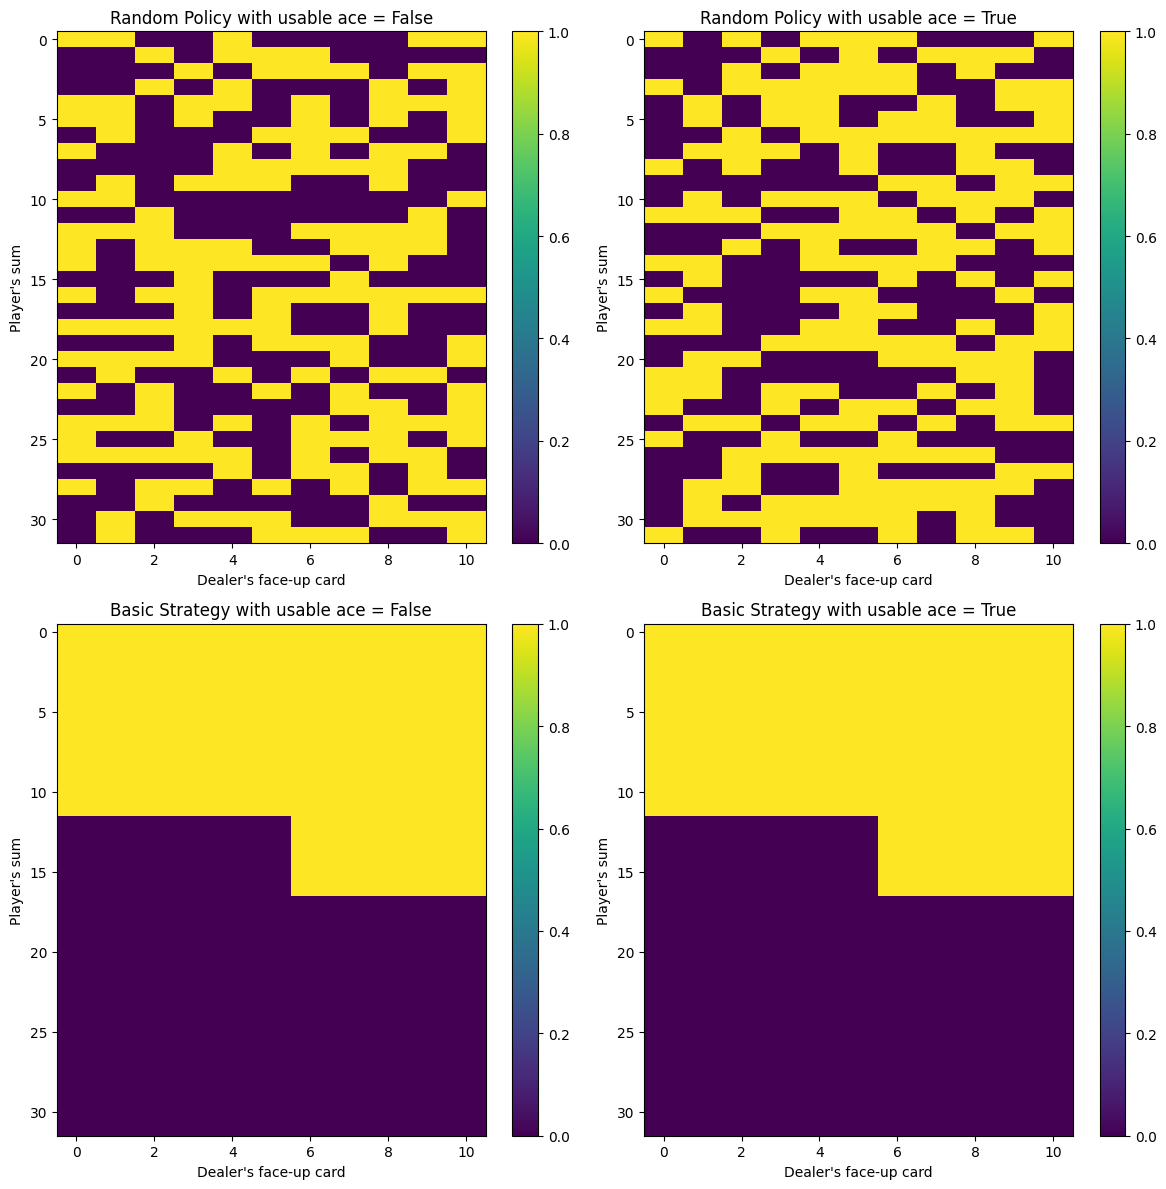

In [5]:
print(# Return the results
{
    "Random Policy": {
        "Win Rate": win_rate_random,
        "Draw Rate": draw_rate_random,
        "Loss Rate": loss_rate_random
    },
    "Basic Strategy": {
        "Win Rate": win_rate_basic,
        "Draw Rate": draw_rate_basic,
        "Loss Rate": loss_rate_basic
    }
})

# Plot the action taken by the random policy
random_policy_actions = np.zeros((32, 11, 2))
for player_sum in range(32):
    for dealer_card in range(1, 12):
        for ace in [0, 1]:
            obs = (player_sum, dealer_card, ace)
            random_policy_actions[player_sum, dealer_card - 1, ace] = random_policy(obs, env)

# Plot the action taken by the basic strategy
basic_strategy_actions = np.zeros((32, 11, 2))
for player_sum in range(32):
    for dealer_card in range(1, 12):
        for ace in [0, 1]:
            obs = (player_sum, dealer_card, ace)
            basic_strategy_actions[player_sum, dealer_card - 1, ace] = basic_strategy(obs, env)

# Plot the actions
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, usable_ace in enumerate([False, True]):
    im = axs[0, i].imshow(random_policy_actions[:, :, int(usable_ace)], aspect="auto")
    axs[0, i].set_title(f"Random Policy with usable ace = {usable_ace}")
    axs[0, i].set_xlabel("Dealer's face-up card")
    axs[0, i].set_ylabel("Player's sum")
    fig.colorbar(im, ax=axs[0, i])

    im = axs[1, i].imshow(basic_strategy_actions[:, :, int(usable_ace)], aspect="auto")
    axs[1, i].set_title(f"Basic Strategy with usable ace = {usable_ace}")
    axs[1, i].set_xlabel("Dealer's face-up card")
    axs[1, i].set_ylabel("Player's sum")
    fig.colorbar(im, ax=axs[1, i])

plt.tight_layout()
plt.show()


---
The goal of this lab is to train models that learn a policy maximizing the win rate. At a minimum, an agent should improve its performance and achieve a win rate higher than that of a Random policy.

**In the case of Blackjack, the game is simple enough that finding a successful policy is relatively easy—you might even discover a strategy that outperforms some of the agents you train in this lab. However, many real-world tasks are far too complex to allow for an obvious winning strategy. This is where reinforcement learning (RL) truly shines. By using the tools introduced in this lab, you will be able to tackle much more challenging problems.**

---

# 1. Defining and Training a tabular Q-Learning agent
*Task 1 is based on the [Training an agent tutorial](https://gymnasium.farama.org/introduction/train_agent/) in Gymnasium's documentation.*

In Task 1, we will implement an tabular Q-learning agent that will use **TD-learning** and a **eplison greedy policy** to learn how to play Blackjack.


<div class="alert alert-block alert-info"> 
<b>💡 Tips</b> 

- Review the following elements of theory, you will need them later.

</div>

### Shape of the Q(s, a) Object in Tabular Q-Learning

In **Tabular Q-Learning**, the **Q-table** is a **2D array (matrix)** where:

$$
Q \in \mathbb{R}^{|\mathcal{S}| \times |\mathcal{A}|}
$$

where:
- $ |\mathcal{S}| $ is the number of discrete states.
- $ |\mathcal{A}| $ is the number of discrete actions.
- Each entry $ Q(s, a) $ represents the estimated **Q-value** for taking action $ a $ in state $ s $.

For example, if an environment has **3 states** and **2 actions**, then at time $t$, $Q(s_t,a_t)$ is:

| State | Action 0 | Action 1 | 
| ----- | -------- | -------- | 
| s0    |Q(s0_t,a0_t)| Q(s0_t,a1_t)|
| s1    |Q(sA_t,a0_t)|Q(s1_t,a1_t)|
| s2    |Q(s2_t,a0_t)|Q(s2_t,a1_t)|


---

### Eplison greedy policy

The **epsilon-greedy policy** is a strategy for balancing **exploration** and **exploitation** in **Reinforcement Learning (RL)**.

**Definition** 

The **epsilon-greedy** policy selects the action with the highest estimated value most of the time (**exploitation**) but occasionally chooses a random action (**exploration**) with a probability of **ε (epsilon)**.

At each time step $t$, the action $a_t$ taken based on the observation $s_t$ is chosen as:


$$
a_t =
\begin{cases}
\arg\max_{a_t} Q(s_t,a_t), & \text{with probability } 1 - \epsilon \quad (\text{greedy choice}) \\
\text{random action}, & \text{with probability } \epsilon \quad (\text{exploration})
\end{cases}
$$

where:
- $Q(s_t,a_t)$ is the estimated q-value of action $a_t$.
- $\epsilon$ (epsilon) is a small value (e.g., 0.1) that controls the trade-off between exploration and exploitation.

To transition the agent from an exploratory phase to a more exploitative one over time, we use the **epsilon decay** technique by reducing the value of epsilon over time.

---

### TD-learning

**Temporal Difference (TD) Learning** is a fundamental method in **Reinforcement Learning (RL)** which allows agents to learn directly from experience without requiring a complete model of the environment.

**Definition**

TD learning updates value estimates using the difference (or "error") between successive estimates. This is called the **TD error**, and is defined as:

$$
Q(s_{t+1},a_{t+1}) \leftarrow Q(s_t,a_t) + \alpha \cdot (r + \gamma \cdot Q(s_t',a_t') - Q(s_t,a_t))
$$

where:
- $ Q(s_{t+1},a_{t+1})$ is the value estimate for state $ s $ according to the next policy.
- $ Q(s_t,a_t) $ is the value estimate for state $ s $ according to the current policy.
- $ \alpha $ is the **learning rate** (step size).
- $ r $ is the **reward** received after taking an action in state $ s $.
- $ \gamma $ is the **discount factor** (determines the importance of future rewards).
- $ Q(s_t',a_t') $ is the estimate of the q-values for the next state $ s' $ according to the current policy.
- $ \delta = r + \gamma Q(s_t',a_t') - Q(s_t,a_t) $ is the **TD error**.




## 1.1 Implementing the agent

The class `TabularQLearningAgent` contains the code needed to define an agent that we will train to learn how to play the Blackjack game.

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Implement the function `get_action` in the class `TabularQLearningAgent` with the eplison greedy policy.
- Implement the function `update` in the class `TabularQLearningAgent` that uses TD Learning to update the `TabularQLearningAgent.q_values` object after a game.
- Implement the function `decay_epsilon` in the class `TabularQLearningAgent` that updates the agent's epsilon parameters until it reaches its final value.

</div>

<div class="alert alert-block alert-info"> 
<b>💡 Tips</b> 

- In the case of our game of Blackjack, there are `2` actions, and `32 * 11 * 2 = 704` states. The Q table will therefore be 704x2 table will all values initialised to 0, and updated during training.
- The `TabularQLearningAgent.q_values` object is a `defaultdict`. This is a special class of key<->pair dictionary that is initialised with a default output. When called with a key , if this key is not recognised, it returns the default output. This object allows for a flexible implementation of the Q table, where only the state<->action pairs that have been updated are stored.

</div>

In [6]:
class TabularQLearningAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay increment for the epsilon value
            final_epsilon: The final epsilon value 
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n)) # Q-values for each state-action pair, it is of the same shape as the action space

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon # epsilon value of the agent
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = [] # temporal difference error for each update

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the action to take given the observation using an epsilon-greedy policy.

        Args:
            obs(tuple): The observation of the environment
                obs[0](int): The player's current sum
                obs[1](int): The dealer's face-up card
                obs[2](bool): Whether the player has a usable ace

        Returns:
            The action to take (0 for stick, 1 for hit)
        """
        # TODO: your code here
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """
        Updates the Q-value of the state-action pair using TD-learning.

        Args:
            obs(tuple): The observation of the environment
                obs[0](int): The player's current sum
                obs[1](int): The dealer's face-up card
                obs[2](bool): Whether the player has a usable ace
            action(int): The action taken
            reward(float): The reward received
            terminated(bool): Whether the episode has terminated
            next_obs(tuple): The next observation of the environment
                next_obs[0](int): The player's current sum
                next_obs[1](int): The dealer's face-up card
                next_obs[2](bool): Whether the player has a usable

        Updated parameters:
            self.q_values: The Q-values for each state-action pair
            self.training_error: The temporal difference error for each update
        
        """

        # Compute the future Q-value of the next observation
        # if the episode has terminated, the future Q-value is 0, otherwise it is the maximum Q-value of the next observation
        # TODO: your code here
        future_q_value = (not terminated) * np.max(self.q_values[next_obs]) # if the episode has terminated, the future Q-value is 0, otherwise it is the maximum Q-value of the next observation

        # TODO: your code here
        # Compute the temporal difference error according to the TD-learning formula which includes the reward, the future Q-value and the current Q-value for the state-action pair
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )


        # Update the Q-value of the state-action pair using the TD-learning formula
        # TODO: your code here
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """
        Decays the epsilon value.
        
        The epsilon value is decayed by the decay increment
        and is clipped to the final epsilon value.

        Updated parameters:
            self.epsilon: The epsilon value of the agent
        """
        # TODO: your code here
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

## 1.2 Training the agent

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Implement the function `train_blackjack_agent` bellow. Each comment `# TODO` indicates that some code must be implemented.

</div>

<div class="alert alert-block alert-info"> 
<b>💡 Tips</b> 

- Run `help(gym.envs.toy_text.blackjack.BlackjackEnv.step)` to print the method's doctring.

</div>

In [7]:
def train_blackjack_tabular_agent(agent, env:gym.envs.toy_text.blackjack.BlackjackEnv, n_episodes:int)->None:
    """
    Trains the agent using the Q-learning algorithm.

    Args:
        agent: The Q-learning agent
        env: The training environment
        n_episodes(int): The number of episodes to train the agent

    """
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset() # reset the environment and get the initial observation
        done = False

        # play one episode
        while not done:
            # get the action from the agent
            # TODO: your code here
            action = agent.get_action(obs)

            # take a step in the environment using the action with BlackjackEnv.step and get the next observation, reward, termination, and truncation
            # TODO: your code here
            next_obs, reward, terminated, truncated, info = env.step(action)

            # update the agent with the observation, action, reward, termination, and next observation
            # TODO: your code here
            agent.update(obs, action, reward, terminated, next_obs)

            # update if the environment is done (terminated or truncated is True)
            # TODO: your code here
            done = terminated or truncated

            # update the observation to the next observation
            # TODO: your code here
            obs = next_obs

        # update the agent's epsilon value
        # TODO: your code here
        agent.decay_epsilon()

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Run the cells bellow to train the agent and visualise the results.

</div>

In [8]:
n_episodes = 100000
env = gym.make('Blackjack-v1', natural=False, sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

# Set hyperparameters
learning_rate = 0.01
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1


# Create the agent
agent_tabular = TabularQLearningAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

# Train the agent
train_blackjack_tabular_agent(agent_tabular, env, n_episodes)

# Print the win rate of the agent
win_rate_tabular = evaluate_blackjack_agent(agent_tabular, env, 1000)
print(f"Win rate of the agent: {win_rate_tabular:.2f}")

100%|██████████| 1000/1000 [00:00<00:00, 4091.67it/s]

Win rate of the agent: 0.24


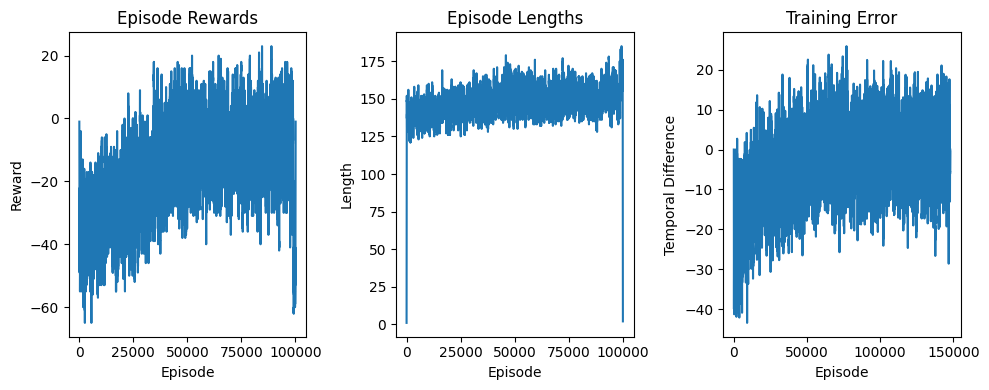

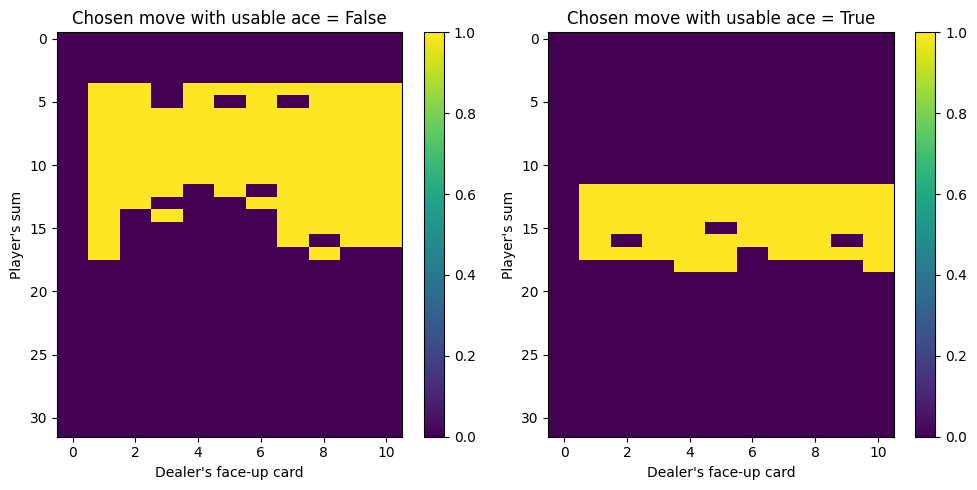

In [9]:
# Visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# np.convolve will compute the rolling mean for 100 episodes
axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent_tabular.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

q_values = unpack_qvalues_dict(agent_tabular.q_values)

# plot the Q-values for the state-action pairs
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, usable_ace in enumerate([False, True]):
    im = axs[i].imshow(q_values[:, :, int(usable_ace)], aspect="auto")
    axs[i].set_title(f"Chosen move with usable ace = {usable_ace}")
    axs[i].set_xlabel("Dealer's face-up card")
    axs[i].set_ylabel("Player's sum")
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()

# 2. Defining and Training a Deep Q-Network agent

In Task 2, we will implement an agent that will use **TD-learning** and an **Artificial Neural Network** to learn how to play Blackjack.

<div class="alert alert-block alert-info"> 
<b>💡 Tips</b> 

- Review the following elements of theory, you will need them later.

</div>

### What is a Q-Network?

A **Q-Network** is a **neural network** that approximates the **Q-value function** $ Q(s, a) $ in **Deep Q-Learning (DQN)**. Instead of using a table to store Q-values for each state-action pair, a Q-Network generalizes Q-values across **large or continuous state spaces**.

**Definition:**

$$
Q(s, a; \theta) \approx Q^*(s, a)
$$

where:
- $ \theta $ are the **neural network weights**.
- $ Q^*(s, a) $ is the **optimal Q-value function**.

---

### How Q-Networks Differ from Tabular Q-Learning

| Feature  | **Tabular Q-Learning** | **Q-Network (DQN)** |
|----------|---------------------|------------------|
| **Representation** | Uses a **Q-table**: $ Q(s, a) $ stored explicitly | Uses a **neural network** to approximate $ Q(s, a) $ |
| **State Space** | Works well for **small** discrete state spaces | Scales to **large** or continuous state spaces |
| **Generalization** | No generalization, each state-action pair is stored explicitly | Generalizes Q-values for unseen states |
| **Memory Usage** | Requires large memory for big state spaces | More memory-efficient due to learned representations |
| **Training Updates** | Q-values updated directly in a lookup table | Neural network weights updated via **gradient descent** |
| **Exploration** | Uses **epsilon-greedy** to explore | Same, but exploration can be improved with **policy-based methods** |
| **Performance in Complex Environments** | Limited to small environments | Works well in high-dimensional spaces like **Atari games** |

---

### How Q-Networks Work (DQN Algorithm)

1. **Initialize** a neural network $ Q(s, a; \theta) $ with random weights.
2. **At each step:**
   - Select an action using **epsilon-greedy** exploration.
   - Execute the action, observe the reward and next state.
   - Compute the **TD target** using the Bellman equation:

     $$
     y = r + \gamma \max_{a'} Q(s', a'; \theta)
     $$

   - Compute the **loss function**:

     $$
     L(\theta) = (y - Q(s, a; \theta))^2
     $$

   - **Update network weights** using **gradient descent**.
3. **Repeat** until convergence.

---

## 2.1 Implement a simple Q-Network agent

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Implement the class `QNetworkModel` in the cell bellow with the following architecture
    - layer 1 : Dense layer with 64 neurons and relu activation function
    - layer 2 : Dense layer with 64 neurons and relu activation function
    - layer 3 : Dense layer with as many neurons as possible actions.

</div>

In [10]:
class QNetworkModel(tf.keras.Model):
    """
    Implements a simple feedforward neural network with two hidden layers for Q-learning.

    """
    def __init__(self, n_actions: int):
        super(QNetworkModel, self).__init__()
        # TODO: your code here
        self.dense1 = tf.keras.layers.Dense(64, activation='relu', input_shape=(3,))
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(n_actions)

    def call(self, inputs):
        """
        Method to call the model on the input tensors. 
        It is called automatically when the model is called with .predict() or .fit().
        """
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Implement the function `get_action` in the class `QNetworkAgent` with the eplison greedy policy.
- Implement the function `update` in the class `QNetworkAgent` that uses TD Learning to update the `QNetworkAgent.DQN` weights using `tf.keras.Model.fit()`.
- Implement the function `decay_epsilon` in the class `QNetworkAgent` that updates the agent's epsilon parameters until it reaches its final value.


</div>

In [11]:
class QNetworkAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.90,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay increment for the epsilon value
            final_epsilon: The final epsilon value 
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.DQN = QNetworkModel(n_actions=2) # Q-values for each state-action pair, it is of the same shape as the action space
        self.DQN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon # epsilon value of the agent
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = [] # temporal difference error for each update

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the action to take given the observation using an epsilon-greedy policy.

        Args:
            obs(tuple): The observation of the environment
                obs[0](int): The player's current sum
                obs[1](int): The dealer's face-up card
                obs[2](bool): Whether the player has a usable ace

        Returns:
            The action to take (0 for stick, 1 for hit)
        """
        # TODO: your code here
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.DQN.predict(np.array([obs]),verbose = 0)))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """
        Updates the Q-values of one or multiple state-action pairs using TD-learning.

        Args:
            obs (tuple or np.ndarray): The observation(s) of the environment.
                If a single observation is provided, it is a tuple of the form:
                    obs[0] (int): The player's current sum.
                    obs[1] (int): The dealer's face-up card.
                    obs[2] (bool): Whether the player has a usable ace.
                If a batch of observations is provided, it is a NumPy array of shape (batch_size, 3).
            
            action (int or np.ndarray): The action(s) taken.
                If a single action is provided, it is an integer (0 for stick, 1 for hit).
                If a batch of actions is provided, it is a NumPy array of shape (batch_size,).
            
            reward (float or np.ndarray): The reward(s) received.
                If a single reward is provided, it is a float.
                If a batch of rewards is provided, it is a NumPy array of shape (batch_size,).

            terminated (bool or np.ndarray): Whether the episode has terminated.
                If a single termination flag is provided, it is a boolean.
                If a batch of termination flags is provided, it is a NumPy array of shape (batch_size,).

            next_obs (tuple or np.ndarray): The next observation(s) of the environment.
                If a single observation is provided, it is a tuple of the form:
                    next_obs[0] (int): The player's current sum.
                    next_obs[1] (int): The dealer's face-up card.
                    next_obs[2] (bool): Whether the player has a usable ace.
                If a batch of next observations is provided, it is a NumPy array of shape (batch_size, 3).

        Updated parameters:
            self.DQN: The Q-network, which is trained using a batch of experience samples.
            self.training_error: The temporal difference error for each update, tracked over the batch.
        """

        # Ensure obs and next_obs are arrays of shape (-1, 3)
        if isinstance(obs, tuple):
            obs = np.array([obs])
        if isinstance(next_obs, tuple):
            next_obs = np.array([next_obs])

        # Calculate the future Q-value. If the episode has terminated, the future Q-value is 0, otherwise it is the maximum Q-value of the next observation
        # TODO: your code here
        future_q_value = (1 - terminated) * np.max(self.DQN.predict(next_obs, verbose=0), axis=1)

        # Calculate the TD target. 
        # The TD target is what the DQN's output will be evaluated against. 
        # For the action taken, the TD target is the reward plus the discounted future Q-value.
        # For the other actions, the TD target is the current Q-value.
        # TODO: your code here
        TD_target = self.DQN.predict(obs, verbose=0)
        TD_target[np.arange(obs.shape[0]), action] = reward + self.discount_factor * future_q_value

        # Update the DQN model using the observations and the TD target with model.fit
        # TODO: your code here
        self.DQN.fit(obs, TD_target, verbose=0)

        # Track training error, which is the mean temporal difference error for the action taken over the batch
        # TODO: your code here
        self.training_error.append(np.mean(TD_target[np.arange(obs.shape[0]), action]))

    def decay_epsilon(self):
        """
        Decays the epsilon value.
        
        The epsilon value is decayed by the decay increment
        and is clipped to the final epsilon value.

        Updated parameters:
            self.epsilon: The epsilon value of the agent
        """
        # TODO: your code here
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

## 2.2 Train the agent

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Implement the function `train_blackjack_DQN_agent` bellow. Each comment `# TODO` indicates that some code must be implemented.

</div>

<div class="alert alert-block alert-info"> 
<b>💡 Tips</b> 

- Run `help(gym.envs.toy_text.blackjack.BlackjackEnv.step)` to print the method's doctring.

</div>

In [12]:
def train_blackjack_DQN_agent(agent, env, n_episodes:int)->None:
    """
    Trains the agent using the Q-learning algorithm.

    Args:
        agent: The Q-learning agent
        env: The training environment
        n_episodes(int): The number of episodes to train the agent

    """
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset() # reset the environment and get the initial observation
        done = False

        # play one episode
        while not done:
            # get the action from the agent
            # TODO: your code here
            action = agent.get_action(obs)

            # take a step in the environment using the action with BlackjackEnv.step and get the next observation, reward, termination, and truncation
            # TODO: your code here
            next_obs, reward, terminated, truncated, info = env.step(action)

            # update the agent with the observation, action, reward, termination, and next observation
            # TODO: your code here
            agent.update(obs, action, reward, terminated, next_obs)

            # update if the environment is done (terminated or truncated is True)
            # TODO: your code here
            done = terminated or truncated

            # update the observation to the next observation
            # TODO: your code here
            obs = next_obs

        # update the agent's epsilon value
        # TODO: your code here
        agent.decay_epsilon()

In [13]:
n_episodes = 2000
env = gym.make('Blackjack-v1', natural=False, sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

# Set hyperparameters
learning_rate = 0.01
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes)  # reduce the exploration over time
final_epsilon = 0.1


# Create the agent
agent = QNetworkAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

# Train the agent
train_blackjack_DQN_agent(agent, env, n_episodes)

# Print the win rate of the agent
win_rate_dqn = evaluate_blackjack_agent(agent, env, 1000)
print(f"Win rate of the agent: {win_rate_dqn:.2f}")

/Users/davidgerard/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
100%|██████████| 1000/1000 [01:41<00:00,  9.84it/s]

Win rate of the agent: 0.38


<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Run the cells bellow to train the agent and visualise the results.

</div>

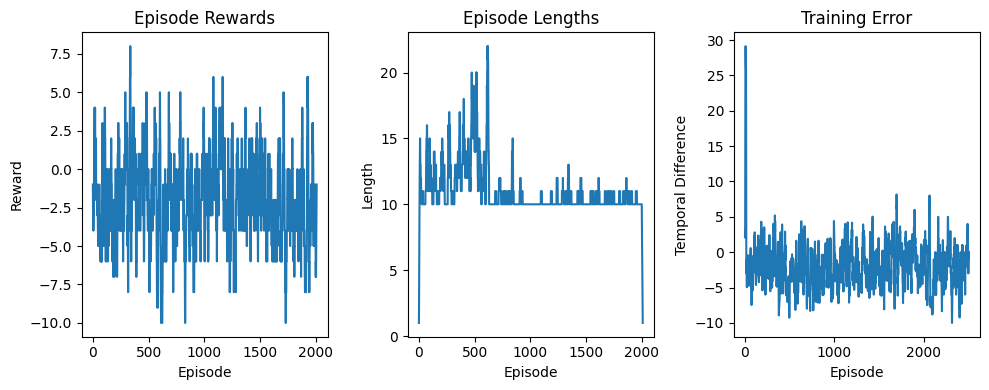

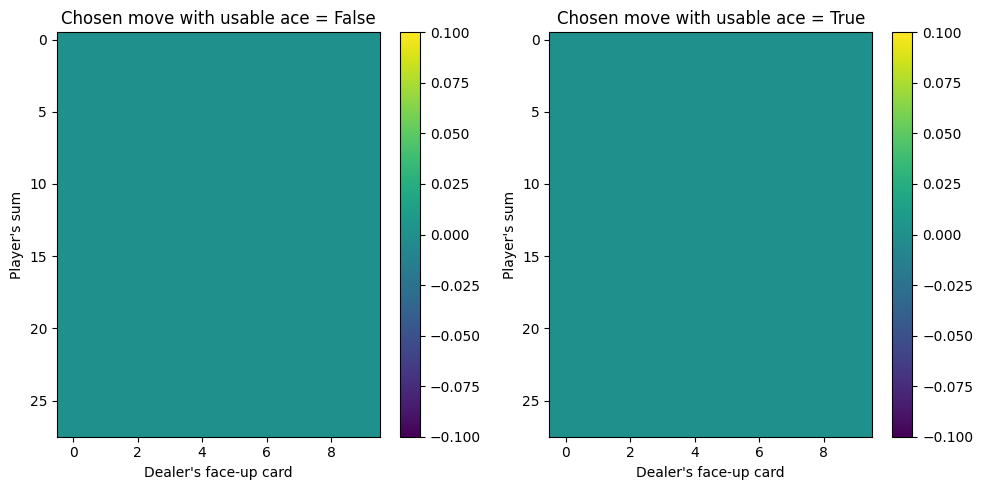

In [14]:
# Visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# np.convolve will compute the rolling mean for 100 episodes
axs[0].plot(np.convolve(env.return_queue, np.ones(10)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(10)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(10)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

q_values = get_best_actions_from_DQN(agent)

# plot the Q-values for the state-action pairs
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, usable_ace in enumerate([False, True]):
    im = axs[i].imshow(q_values[:, :, int(usable_ace)], aspect="auto")
    axs[i].set_title(f"Chosen move with usable ace = {usable_ace}")
    axs[i].set_xlabel("Dealer's face-up card")
    axs[i].set_ylabel("Player's sum")
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()

# 3. Improving the DQN agent's performences

## 3.1 Speeding up learning with experience replay


During our experiments, we observed that the **performance of the Deep Q-Network (DQN) was poor**, and training was **extremely slow**. This can be explained by:

1. **Lack of Batch Updates**: The agent updated the Q-network **after every step**, using a single experience sample. This is inneficient as it **does not take advantage of vectorization**.
2. **Correlated Training Data**: Each update was based on the **most recent transition**, meaning that consecutive updates were highly correlated.  
3. **Inefficient Use of Data**: Once a transition was used for training, it was discarded, leading to **slow convergence**.  

To address these issues, we introduce **Experience Replay**, a technique that significantly improves training efficiency and stability.

---

### Experience Replay

**Experience Replay** is a mechanism where the agent **stores past experiences** (state, action, reward, next state, done flag) in a **replay buffer**. Instead of updating the Q-network after every step, the agent **samples a batch of past experiences** and trains on them in a more efficient way.


**Definition:**

1. **Store Experiences**: Every transition $(s, a, r, s', \text{done})$ is stored in a **replay buffer** (a fixed-size memory).  
2. **Sample a Batch**: Instead of using only the latest experience, we **randomly sample a batch** of experiences from the buffer.  
3. **Compute TD Target**: For each sampled transition, compute the **TD target**:

   $$
   y = r + \gamma \max_{a'} Q(s', a')
   $$

4. **Train on the Batch**: The Q-network is updated using a **mini-batch gradient descent** step, rather than a single experience.  
5. **Repeat**: This process continues throughout training.


**Implementation:**

Training a DQN with experience Replay consists of two distinct **phases**:

**Initialization Phase** (Filling the Replay Buffer)  
- Initially, the agent **collects experience** by interacting with the environment **without training**.  
- The DQN **runs as before**, updating after each step, but only **stores transitions** in the buffer.  
- This ensures that we have **diverse experiences** before starting training.

**Batch Training Phase** (Experience Replay Training)  
- Once the **buffer is filled**, we start **training using mini-batches** from stored experiences.  
- Instead of learning from just the latest experience, we **sample a batch of past transitions** randomly.
- The agent **trains more efficiently** by learning from **uncorrelated experiences**.

---


<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Using the `ExperienceReplayBuffer`class defined in `utils.py`, implement the function `train_blackjack_DQN_agent_experience_replay` defined in the cell bellow.

</div>

In [15]:
def train_blackjack_DQN_agent_experience_replay(agent, env:gym.envs.toy_text.blackjack.BlackjackEnv, n_episodes:int, batch_size:int, buffer_size:int)->None:
    """
    Trains the agent using the Q-learning algorithm.

    Args:
        agent: The Q-learning agent
        env: The training environment
        n_episodes(int): The number of episodes to train the agent
        batch_size(int): The batch size for experience replay
        buffer_size(int): The size of the experience replay buffer


    """
    # Define the experience replay buffer
    # TODO: your code here
    experience = ExperienceReplayBuffer(buffer_size)
    

    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset() # reset the environment and get the initial observation
        done = False

        # play one episode
        while not done:
            # get the action from the agent
            # TODO: your code here
            action = agent.get_action(obs)

            # take a step in the environment using the action with BlackjackEnv.step and get the next observation, reward, termination, and truncation
            # TODO: your code here
            next_obs, reward, terminated, truncated, info = env.step(action)

            # add the experience to the buffer
            # TODO: your code here
            experience.add((obs, action, reward, terminated, next_obs))

            # update the agent using experience replay if the buffer has been filled, otherwise update the agent using the last experience
            if experience.full: # if the buffer is full, sample a batch of experiences and update the agent
                # TODO: your code here
                obs_batch, action_batch, reward_batch, terminated_batch, next_obs_batch = experience.sample(batch_size)
                agent.update(obs_batch, action_batch, reward_batch, terminated_batch, next_obs_batch)
            else: # we're in the initial phase of training, update the agent with the last experience
                # TODO: your code here
                agent.update(obs, action, reward, terminated, next_obs)
            
            # update if the environment is done (terminated or truncated is True)
            # TODO: your code here
            done = terminated or truncated

            # update the observation to the next observation
            # TODO: your code here
            obs = next_obs

        # update the agent's epsilon value
        # TODO: your code here
        agent.decay_epsilon()

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Run the cells bellow to train the agent and visualise the results.

</div>

In [16]:
n_episodes = 2000
env = gym.make('Blackjack-v1', natural=False, sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

# Set hyperparameters
learning_rate = 0.01
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes)  # reduce the exploration over time
final_epsilon = 0.1


# Create the agent
agent = QNetworkAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

# Train the agent
train_blackjack_DQN_agent_experience_replay(agent, env, n_episodes, 10, 1000)

# Print the win rate of the agent
win_rate_exp_replay_dqn = evaluate_blackjack_agent(agent, env, 1000)
print(f"Win rate of the agent: {win_rate_exp_replay_dqn:.2f}")

100%|██████████| 1000/1000 [01:23<00:00, 11.95it/s]

Win rate of the agent: 0.36


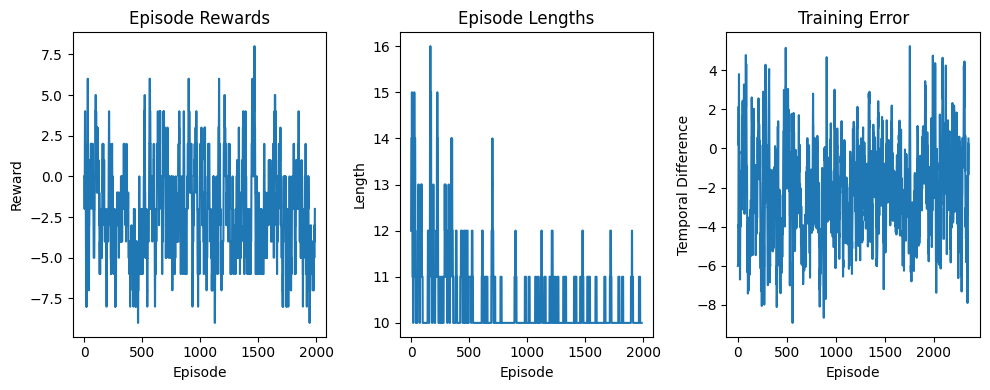

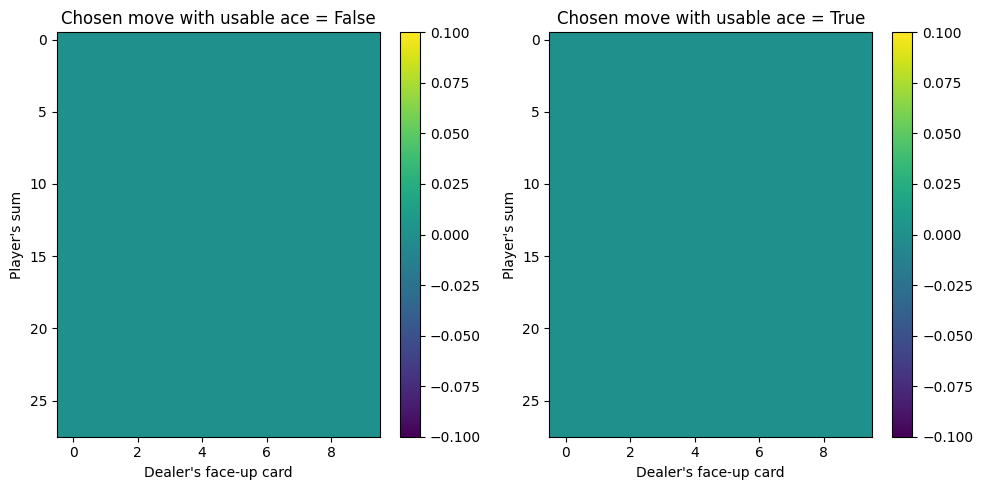

In [17]:
# Visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# np.convolve will compute the rolling mean for 5 episodes
axs[0].plot(np.convolve(env.return_queue, np.ones(10))[10:-10])
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(10))[10:-10])
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(10))[10:-10])
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

q_values = get_best_actions_from_DQN(agent)

# plot the Q-values for the state-action pairs
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, usable_ace in enumerate([False, True]):
    im = axs[i].imshow(q_values[:, :, int(usable_ace)], aspect="auto")
    axs[i].set_title(f"Chosen move with usable ace = {usable_ace}")
    axs[i].set_xlabel("Dealer's face-up card")
    axs[i].set_ylabel("Player's sum")
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()

## 3.2 Increasing stability with double DQN

Even after implementing **Experience Replay**, we observed that **DQN training remains highly unstable**.  
From one training run to another, the **final performance varies significantly**, and the agent sometimes learns **suboptimal policies**. This is because:

1. **Overestimation Bias in Q-Values**  
   - In standard DQN, we use the **max Q-value** from the target network to compute the TD target:
     $$
     y = r + \gamma \max_{a'} Q(s', a')
     $$
   - This causes the network to **overestimate Q-values**, since it selects the same action for evaluation and target calculation.
   - These overestimations **compound over time**, leading to **unstable training**.

2. **Large Training Variability Across Runs**  
   - Due to overestimation, **small differences in early learning** lead to **major differences in final performance**.
   - One run might converge to an **optimal policy**, while another might **fail completely**.

---

### Double DQN (DDQN)

**Double DQN (DDQN)** is a simple yet powerful modification to DQN that **reduces overestimation bias** and makes training more stable.  


Instead of using the **same Q-network** for both action selection and value estimation, **Double DQN separates these roles** by using:  
- The **main network** to **select the action** ($a^*$).
- The **target network** to **evaluate its Q-value**.

**Definition:**  

Instead of computing the target as:  
$$
y = r + \gamma \max_{a'} Q_{\text{target}}(s', a')
$$
We modify it to:  
$$
y = r + \gamma Q_{\text{target}}(s', \arg\max_{a'} Q_{\text{main}}(s', a'))
$$
Here’s what changes:  
1. **Action Selection:** The **main network** picks the best action $ a^* = \arg\max Q_{\text{main}}(s', a') $.  
2. **Value Estimation:** The **target network** evaluates this action’s value.  

This prevents the **overestimation problem** and makes training more **stable** across different runs.

---

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Implement the function `get_action` in the class `DoubleQNetworkAgent` with the eplison greedy policy with the main DQN.
- Implement the function `update` in the class `DoubleQNetworkAgent` that uses TD Learning to update the `DoubleQNetworkAgent.mainDQN` weights using doubleDQN `tf.keras.Model.fit()`.
- Implement the function `update_target_DQN` in the class `DoubleQNetworkAgent` that updates the target DQN with the main DQN's weights using [`DoubleQNetworkAgent.mainDQN.get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/Layer#get_weights) and [``DoubleQNetworkAgent.targetDQN.set_weights`](https://www.tensorflow.org/api_docs/python/tf/keras/Layer#set_weights).
- Implement the function `decay_epsilon` in the class `DoubleQNetworkAgent` that updates the agent's epsilon parameters until it reaches its final value.


</div>

In [18]:
class DoubleQNetworkAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.90,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay increment for the epsilon value
            final_epsilon: The final epsilon value 
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env

        self.mainDQN = QNetworkModel(n_actions=2) # Q-values for each state-action pair, it is of the same shape as the action space
        self.mainDQN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

        self.targetDQN = QNetworkModel(n_actions=2) # Q-values for each state-action pair, it is of the same shape as the action space
        self.targetDQN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon # epsilon value of the agent
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = [] # temporal difference error for each update

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the action to take given the observation using an epsilon-greedy policy.

        Args:
            obs(tuple): The observation of the environment
                obs[0](int): The player's current sum
                obs[1](int): The dealer's face-up card
                obs[2](bool): Whether the player has a usable ace

        Returns:
            The action to take (0 for stick, 1 for hit)
        """
        # TODO: your code here
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.mainDQN.predict(np.array([obs]),verbose = 0)))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """
        Updates the Q-value of the state-action pair using Double DQN.
        """
        # Convert input to NumPy arrays
        if isinstance(obs, tuple):
            obs = np.array([obs])
        if isinstance(next_obs, tuple):
            next_obs = np.array([next_obs])

        # Get action selection from main network for next observation
        # hint: for each next observation in the bacth, get the action {0 or 1} with the highest Q-value outputed by the main network
        # TODO: your code here
        best_action = np.argmax(self.mainDQN.predict(next_obs, verbose=0), axis=1)

        # Use target network to predict Q-values for the best action for the next observation
        # TODO: your code here
        target_q_values = self.targetDQN.predict(next_obs, verbose=0)

        # Compute future Q-value
        # hint: if the episode has terminated, the future Q-value is 0,
        # otherwise the future Q-value is the Q-value of the best action in the next observation
        # TODO: your code here
        future_q_value = (1 - terminated) * target_q_values[np.arange(len(best_action)), best_action]

        # Compute TD target
        # We start with the current Q-values, and we update the Q-value of the action taken
        TD_target = self.mainDQN.predict(obs, verbose=0)  # Start with current Q-values
        TD_target[np.arange(obs.shape[0]), action] = reward + self.discount_factor * future_q_value # TODO: your code here

        # Update the DQN model using the observations and the TD target with model.fit
        # TODO: your code here
        self.mainDQN.fit(obs, TD_target, verbose=0)

        # Track training error, which is the mean temporal difference error for the action taken over the batch
        # TODO: your code here
        self.training_error.append(np.mean(TD_target[np.arange(obs.shape[0]), action]))


    def update_target_DQN(self):
        """
        Update the target DQN with the weights of the main DQN.

        Updated parameters:
            self.targetDQN: The target DQN model
        """
        # Get the weights of the main DQN, and set them as the weights of the target DQN
        # TODO: your code here
        self.targetDQN.set_weights(self.mainDQN.get_weights())

    def decay_epsilon(self):
        """
        Decays the epsilon value.
        
        The epsilon value is decayed by the decay increment
        and is clipped to the final epsilon value.

        Updated parameters:
            self.epsilon: The epsilon value of the agent
        """
        # TODO: your code here
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Implement the function `train_blackjack_double_DQN_agent_experience_replay` defined in the cell bellow. It's the exact same function as `train_blackjack_DQN_agent_experience_replay`, but wit the addition of having to update the weights of the target network periodically.

</div>

In [19]:
def train_blackjack_double_DQN_agent_experience_replay(agent, env:gym.envs.toy_text.blackjack.BlackjackEnv, n_episodes:int, batch_size:int, buffer_size:int, n_episodes_for_target_DQN_update=5)->None:
    """
    Trains the agent using the Q-learning algorithm. The agent uses Double DQN and experience replay.
    The weights of the target DQN are updated every n_episodes_for_target_DQN_update episodes.

    Args:
        agent: The Q-learning agent
        env: The training environment
        n_episodes(int): The number of episodes to train the agent
        batch_size(int): The batch size for experience replay
        buffer_size(int): The size of the experience replay buffer
        n_episodes_for_target_DQN_update(int): The number of episodes before updating the target DQN


    """
    # TODO: your code here (this time you don't get help from me)
    experience = ExperienceReplayBuffer(buffer_size)
    

    for episode in tqdm(range(n_episodes)):

        obs, info = env.reset() # reset the environment and get the initial observation
        done = False

        # play one episode
        while not done:
            # get the action from the agent             
            action = agent.get_action(obs)

            # take a step in the environment using the action with BlackjackEnv.step
            next_obs, reward, terminated, truncated, info = env.step(action)

            # add the experience to the buffer
            experience.add((obs, action, reward, terminated, next_obs))

            # update the agent using experience replay if the buffer has been filled, otherwise update the agent using the last experience
            if experience.full:
                obs_batch, action_batch, reward_batch, terminated_batch, next_obs_batch = experience.sample(batch_size)
                agent.update(obs_batch, action_batch, reward_batch, terminated_batch, next_obs_batch)
            else:
                agent.update(obs, action, reward, terminated, next_obs)
            
            # update if the environment is done
            done = terminated or truncated

            # update the observation
            obs = next_obs

        # update the agent's epsilon value
        agent.decay_epsilon()

        if episode % n_episodes_for_target_DQN_update == 0:
            agent.update_target_DQN()

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Run the cells bellow to train the agent and visualise the results.

</div>

In [20]:
n_episodes = 2000
# Set hyperparameters
learning_rate = 0.01
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes)  # reduce the exploration over time
final_epsilon = 0.1


# Create the agent
agent_double_DQN = DoubleQNetworkAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

# Train the agent
train_blackjack_double_DQN_agent_experience_replay(agent_double_DQN, env, n_episodes, 10, 5)

# Print the win rate of the agent
win_rate_double_dqn = evaluate_blackjack_agent(agent_double_DQN, env, 1000)
print(f"Win rate of the agent: {win_rate_double_dqn:.2f}")

100%|██████████| 1000/1000 [01:32<00:00, 10.76it/s]

Win rate of the agent: 0.38


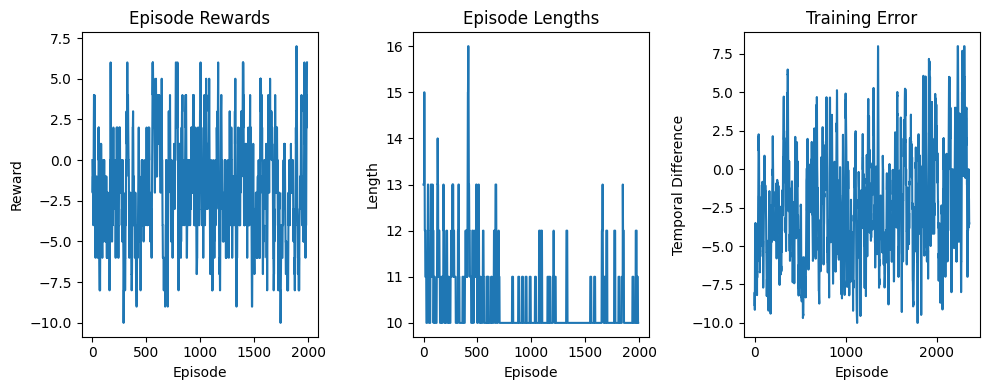

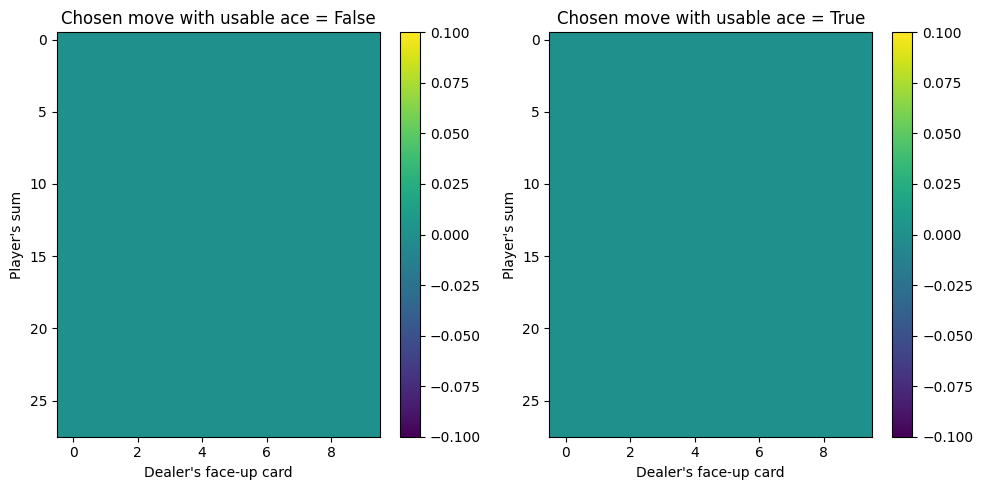

In [21]:
# Visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# np.convolve will compute the rolling mean for 5 episodes
axs[0].plot(np.convolve(env.return_queue, np.ones(10))[10:-10])
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(10))[10:-10])
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent_double_DQN.training_error, np.ones(10))[10:-10])
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

q_values = get_best_actions_from_DQN(agent_double_DQN, double_DQN = True)

# plot the Q-values for the state-action pairs
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, usable_ace in enumerate([False, True]):
    im = axs[i].imshow(q_values[:, :, int(usable_ace)], aspect="auto")
    axs[i].set_title(f"Chosen move with usable ace = {usable_ace}")
    axs[i].set_xlabel("Dealer's face-up card")
    axs[i].set_ylabel("Player's sum")
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-danger">
<b>👩‍💻👨‍💻 Action required</b>

- Run the cells bellow to compare the performances of all the agents we trained in this lab.

</div>

In [24]:
# Print benchmark results
print("Benchmark results:")
print(f"Win rate of the random policy: {win_rate_random:.2f}")
print(f"Win rate of the basic strategy: {win_rate_basic:.2f}")

# Print all agents' win rates
print("\nWin rates of the agents:")
print(f"Win rate of the tabular agent: {win_rate_tabular:.2f}")
print(f"Win rate of the DQN agent: {win_rate_dqn:.2f}")
print(f"Win rate of the DQN agent with experience replay: {win_rate_exp_replay_dqn:.2f}")
print(f"Win rate of the Double DQN agent with experience replay: {win_rate_double_dqn:.2f}")

Benchmark results:
Win rate of the random policy: 0.28
Win rate of the basic strategy: 0.42

Win rates of the agents:
Win rate of the tabular agent: 0.24
Win rate of the DQN agent: 0.38
Win rate of the DQN agent with experience replay: 0.36
Win rate of the Double DQN agent with experience replay: 0.38


## 3.3 To go further

In this lab, we have attempted to use RL techniques to learn policies to maximise the changes of winning a simple blackjack game. You are now equiped with a basic understanding of these technics, but if you want to truelly master them, you need to dig deeper into the field. 

The following is a list of ressources you can use should you wish to learn more about reinforcment learning.

<div class="alert alert-block alert-warning">
<h4>👩‍💻 [Optional]</h4>

- Train agents on [more complex environments](https://gymnasium.farama.org/environments/third_party_environments/) with Gymnasium.
- Go through Hugging Face's free online course on [Deep Reinforcement Learning](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction).
- Read academic papers on RL, such as [`SIMPLIFYING DEEP TEMPORAL DIFFERENCE LEARNING`](https://arxiv.org/pdf/2407.04811v2).
- Get into [Transformers Reinforcement Learning](https://huggingface.co/docs/trl/en/index). 

</div>